In [5]:
import folium
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile
import pickle
import random
import gams_magic

### The main work of this notebook is to provide a more detailed visualization for wisconsin data
We might need to project the data to normal CRS

In [2]:
m = folium.Map(location=[43.0819, -89.5579])

In [3]:
m

## Visualize Shape Data

In [8]:
#read link data
road_file_path = os.path.join('..','road_file.csv')
road_file = pd.read_csv(road_file_path,names=["RDWY_LINK_ID","REF_SITE_FROM_ID","REF_SITE_TO_ID"])

In [104]:
# read road shape
shape_path = os.path.join("..","transportation_data","Middleton_Cross_Plains","Features","Middleton_Road_New.shp")
shape = shapefile.Reader(shape_path)

# read crash shape
crash_path = os.path.join("..","transportation_data","Middleton_Cross_Plains","Features","Crash_data_combined_2017_2020.shp")
crash = shapefile.Reader(crash_path)

# load reference point coordinate
reference_coordinate = None
reference_path = os.path.join("..","reference_coordinate")

with open(reference_path, 'rb') as f:
    reference_coordinate = pickle.load(f)

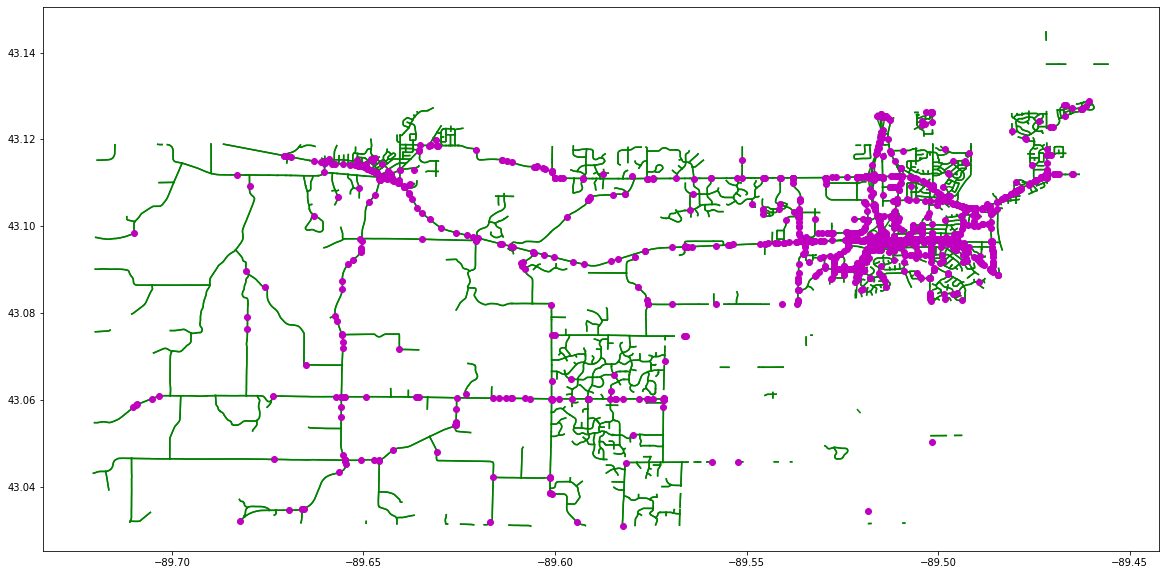

In [107]:
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()

crash_coordinate = []

all_roadId = list(road_file['RDWY_LINK_ID'])
for sp in shape.shapeRecords():
    road_id = sp.record[43]
    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
    plt.plot(x,y,'g')
    
for sp in crash.shapeRecords():
    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
    crash_coordinate.append((y[0],x[0]))
    plt.plot(x,y,'mo')
    
plt.show()

In [48]:
m = folium.Map(location=[43.0819, -89.5579])
for i in range(len(crash_coordinate)):
    folium.CircleMarker(
      location=crash_coordinate[i],
      radius = 0.25,
      color = '#335fff',
      opacity = 0.8
    ).add_to(m)

In [49]:
m

### Solve path for this model

In [162]:
%reload_ext gams_magic
%gams_cleanup -k
%gams_reset

In [163]:
%%gams
$title shortest path try

option limcol = 0, limrow = 0, solprint = off;
set
    nodes
    roadID
    season
    seriousness /K, A, B, C, O/;
;

alias (nodes,i,j);
$gdxin ../link_file.gdx
$loadm nodes=dim1 nodes=dim2
parameter distance(nodes,nodes) distance of a road;
$load  distance=link
$gdxin

$gdxin ../road_file.gdx
set road(roadID<,nodes,nodes);
$load  road=road
$gdxin

$gdxin ../crash_file.gdx
parameter  crash(nodes,nodes) number of crashes on a road;
$load  crash=crash
$gdxin

$gdxin ../crash_seriousness.gdx
$load season=dim3
parameter crashS(nodes,nodes,season,seriousness) number of crashes on a road with different seasons and seriousness;
$load  crashS=serious_crash
$gdxin





set arc(nodes,nodes);

arc(i,j) = no;
arc(i,j)$(distance(i,j) > 0.5) = yes;

parameter
    supply(nodes)
;

scalar origin,destination;
execseed = 1 + gmillisec(jnow);
origin = uniformint(1,card(nodes));
destination = uniformint(1,card(nodes));

*supply(nodes)$(ord(nodes) = origin) = 1;

*supply(nodes)$(ord(nodes) = destination) = -1;

supply('1664291') = 1;
supply('1662117') = -1;

free variable
    total_dist
;

integer variable
    flow(i,j)
;

flow.lo(i,j) = 0

equation
    balance(nodes)
    objective_shortestPath
    objective_safestPath
;


balance(i)..
    sum(arc(i,j), flow(i,j)) - sum(arc(j,i), flow(j,i)) =e= supply(i);
    
objective_shortestPath..
    total_dist =e= sum(arc(i,j),flow(i,j)*distance(i,j) + 10000*flow(i,j)*crash(i,j));



model seasonalPath /balance, objective_shortestPath/;


set roadChosen(season,roadID);

roadChosen(season,roadID) = no;

parameter seasonLength(season)
        seasonCrash(season);

scalar total;
parameter  originalCrash(nodes,nodes);

loop(season,
* using crash number as edge weights
crash(i,j) = sum((seriousness), (6-ord(seriousness))*crashS(i,j,season,seriousness));
originalCrash(i,j) = sum((seriousness), 1*crashS(i,j,season,seriousness));


solve seasonalPath using mip minimizing total_dist;

roadChosen(season,roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosen(season,roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;
seasonLength(season) = sum(road(roadID,i,j)$roadChosen(season,roadID), distance(i,j));
seasonCrash(season) = sum(road(roadID,i,j)$roadChosen(season,roadID), originalCrash(i,j));

);




,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),68898.0,1319,3133,MIP,CPLEX,0.048
1,Normal (1),Optimal Global (1),71041.0,1319,3133,MIP,CPLEX,0.046
2,Normal (1),Optimal Global (1),66470.0,1319,3133,MIP,CPLEX,0.044
3,Normal (1),Optimal Global (1),55044.0,1319,3133,MIP,CPLEX,0.056


In [164]:
%gams_pull -d roadChosen
%gams_pull supply
%gams_pull -d seasonLength
%gams_pull -d seasonCrash

In [165]:
# get the chosen road
chosen_road_safe = {}

for s in ['spring','summer','fall','winter']:
    chosen_road_safe[s] = [ int(road) for road in roadChosen[roadChosen['season'] == s]['roadID']]

# get the chosen origin and destination
origin = None
destination = None
for i in supply:
    if i[1] == 1:
        origin = int(i[0])
    else:
        destination = int(i[0])                                                                                   

In [170]:
# get the crash
seasonal_crash_coord = {'spring':[],'summer':[], 'fall':[],'winter':[]}
for cr in crash.shapeRecords():
    x = [i[0] for i in cr.shape.points[:]]
    y = [i[1] for i in cr.shape.points[:]]
    month = cr.record[2].month
    roadID = cr.record[-3]
    seriousness = cr.record[26]
    if (0 <= month %12 <= 2) and roadID in chosen_road_safe['spring'] + chosen_road_safe['winter']:
        seasonal_crash_coord['winter'].append(((y[0],x[0]),seriousness))
        
    elif (3 <= month %12 <= 5) and roadID in chosen_road_safe['spring'] + chosen_road_safe['winter']:
        seasonal_crash_coord['spring'].append(((y[0],x[0]),seriousness))
        
#     elif (6 <= month %12 <= 8) and roadID in chosen_road_safe['summer']:
#         seasonal_crash_coord['summer'].append((y[0],x[0]))
    
#     elif (9 <= month %12 <= 11) and roadID in chosen_road_safe['fall']:
#         seasonal_crash_coord['fall'].append((y[0],x[0]))

In [171]:
#for s in ['spring','summer','fall','winter']:
chosen_safe = {}
for s in ['spring','winter']:    
    chosen_safe[s] = []
    
    #plot original map 
    for sp in shape.shapeRecords():
        road_id = sp.record[43]

        x = [i[0] for i in sp.shape.points[:]]
        y = [i[1] for i in sp.shape.points[:]]
        
        #record chosen road
        if road_id in chosen_road_safe[s]:
            segment = []
            for i in range(len(x)):
                segment.append((y[i],x[i]))
            chosen_safe[s].append(segment)

In [172]:
m = folium.Map(location=[43.0819, -89.5579])
for loc in chosen_safe['spring']:
    folium.PolyLine(loc,
                color='red',
                weight=3,
                opacity=0.8).add_to(m)
    
for loc in chosen_safe['winter']:
    folium.PolyLine(loc,
                color='blue',
                weight=2,
                opacity=0.5).add_to(m)
    
for Crash in seasonal_crash_coord['spring']:
    folium.CircleMarker(
      location=Crash[0],
      radius = 2,
      color = '#ff3333',
      opacity = 0.8,
      popup = Crash[1]
    ).add_to(m)
    
for Crash in seasonal_crash_coord['winter']:
    folium.CircleMarker(
      location=Crash[0],
      radius = 2,
      color = '#3388ff',
      opacity = 0.8,
      popup = Crash[1]
    ).add_to(m)

In [173]:

m

# Compare with alpha = 1000

In [178]:
%reload_ext gams_magic
%gams_cleanup -k
%gams_reset

In [179]:
%%gams
$title shortest path try

option limcol = 0, limrow = 0, solprint = off;
set
    nodes
    roadID
    season
    seriousness /K, A, B, C, O/;
;

alias (nodes,i,j);
$gdxin ../link_file.gdx
$loadm nodes=dim1 nodes=dim2
parameter distance(nodes,nodes) distance of a road;
$load  distance=link
$gdxin

$gdxin ../road_file.gdx
set road(roadID<,nodes,nodes);
$load  road=road
$gdxin

$gdxin ../crash_file.gdx
parameter  crash(nodes,nodes) number of crashes on a road;
$load  crash=crash
$gdxin

$gdxin ../crash_seriousness.gdx
$load season=dim3
parameter crashS(nodes,nodes,season,seriousness) number of crashes on a road with different seasons and seriousness;
$load  crashS=serious_crash
$gdxin





set arc(nodes,nodes);

arc(i,j) = no;
arc(i,j)$(distance(i,j) > 0.5) = yes;

parameter
    supply(nodes)
;

scalar origin,destination;
execseed = 1 + gmillisec(jnow);
origin = uniformint(1,card(nodes));
destination = uniformint(1,card(nodes));

*supply(nodes)$(ord(nodes) = origin) = 1;

*supply(nodes)$(ord(nodes) = destination) = -1;

supply('1664291') = 1;
supply('1662117') = -1;

free variable
    total_dist
;

integer variable
    flow(i,j)
;

flow.lo(i,j) = 0

equation
    balance(nodes)
    objective_shortestPath
    objective_safestPath
;


balance(i)..
    sum(arc(i,j), flow(i,j)) - sum(arc(j,i), flow(j,i)) =e= supply(i);
    
objective_shortestPath..
    total_dist =e= sum(arc(i,j),flow(i,j)*distance(i,j) + 1000*flow(i,j)*crash(i,j));



model seasonalPath /balance, objective_shortestPath/;


set roadChosen(season,roadID);

roadChosen(season,roadID) = no;

parameter seasonLength(season)
        seasonCrash(season);

scalar total;
parameter  originalCrash(nodes,nodes);

loop(season,
* using crash number as edge weights
crash(i,j) = sum((seriousness), (6-ord(seriousness))*crashS(i,j,season,seriousness));
originalCrash(i,j) = sum((seriousness), 1*crashS(i,j,season,seriousness));


solve seasonalPath using mip minimizing total_dist;

roadChosen(season,roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosen(season,roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;
seasonLength(season) = sum(road(roadID,i,j)$roadChosen(season,roadID), distance(i,j));
seasonCrash(season) = sum(road(roadID,i,j)$roadChosen(season,roadID), originalCrash(i,j));

);

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),51622.0,1319,3133,MIP,CPLEX,0.044
1,Normal (1),Optimal Global (1),52214.0,1319,3133,MIP,CPLEX,0.046
2,Normal (1),Optimal Global (1),50616.0,1319,3133,MIP,CPLEX,0.051
3,Normal (1),Optimal Global (1),48616.0,1319,3133,MIP,CPLEX,0.049


In [180]:
%gams_pull -d roadChosen

In [181]:
# get the chosen road
chosen_road_safe = {}

for s in ['spring','summer','fall','winter']:
    chosen_road_safe[s] = [ int(road) for road in roadChosen[roadChosen['season'] == s]['roadID']]

# get the chosen origin and destination
origin = None
destination = None
for i in supply:
    if i[1] == 1:
        origin = int(i[0])
    else:
        destination = int(i[0]) 

In [182]:
#for s in ['spring','summer','fall','winter']:
chosen_safe_1000 = {}
for s in ['spring','winter']:    
    chosen_safe_1000[s] = []
    
    #plot original map 
    for sp in shape.shapeRecords():
        road_id = sp.record[43]

        x = [i[0] for i in sp.shape.points[:]]
        y = [i[1] for i in sp.shape.points[:]]
        
        #record chosen road
        if road_id in chosen_road_safe[s]:
            segment = []
            for i in range(len(x)):
                segment.append((y[i],x[i]))
            chosen_safe_1000[s].append(segment)

In [183]:
m = folium.Map(location=[43.0819, -89.5579])
for loc in chosen_safe['spring']:
    folium.PolyLine(loc,
                color='red',
                weight=3,
                opacity=0.8).add_to(m)
    
for loc in chosen_safe_1000['spring']:
    folium.PolyLine(loc,
                color='blue',
                weight=2,
                opacity=0.5).add_to(m)

In [184]:
m